## Using Copernicus Digital Elevation Model (DEM) data with the Planetary Computer STAC API

The Copernicus digital elevation model is derived from the WorldDEMTM digital surface model based on the radar satellite data acquired during the TanDEM-X Mission. The Planetary Computer hosts these data as Cloud Optimized GeoTIFFs in two resolutions, 90m and 30m.

For this example, we will find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Perform a STAC API query against the finer resolution `cop-dem-glo-30` collection for our point of interest. 

In [2]:
grand_canyon = [-112.15, 36.05]
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates": grand_canyon},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 1 items


A single item was returned which includes the elevation data and additional assets for quick visualization.

In [3]:
list(items[0].assets)

['data', 'tilejson', 'rendered_preview']

We can load the tile into an xarray after signing the HREF using `planetary_computer.sign`. Here we are downsampling the data to reduce the image size for this notebook.

In [4]:
import planetary_computer
import rioxarray

signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)

With the data loaded, we can use `xarray-spatial` to generate a shaded relief.

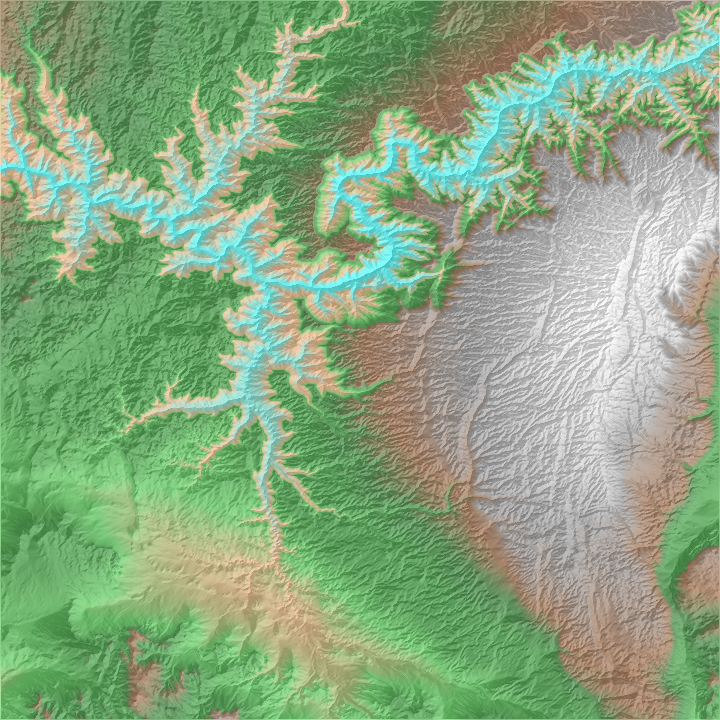

In [5]:
import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data, cmap=Elevation, alpha=128))